In [1]:
# import yahoo finance data
import yfinance as yf
# import stockstats data
from stockstats import StockDataFrame as ss

# import necessary libraries
import matplotlib as mp
import numpy as np
import pandas as pd
import pytz
import warnings
import time
import random
import statistics
import pydoc
import os
import pyarrow
import pandas_gbq
import statsmodels
import tensorflow

#import libraries for SARIMA model
import pmdarima as pm
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pickle
from datetime import datetime
from datetime import timedelta
from datetime import date

2024-01-05 18:56:30.006367: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-05 18:56:30.808653: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-05 18:56:30.808838: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-05 18:56:30.976599: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-05 18:56:31.329619: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-05 18:56:31.334428: I tensorflow/core/platform/cpu_feature_guard.cc:1

Download Data for Apple Stock

In [2]:
apple_ticker = yf.Ticker("AAPL")
apple_data = yf.download("AAPL", start = '2004-01-01', interval = '1d')
apple_df = ss.retype(apple_data)

apple_data[['stochrsi', 'macd', 'mfi']] = apple_df[['stochrsi', 'macd', 'mfi']]
print(apple_data)
print(apple_ticker.get_capital_gains)

[*********************100%%**********************]  1 of 1 completed
                  open        high         low       close   adj close  \
Date                                                                     
2004-01-02    0.384821    0.388393    0.378214    0.380000    0.322118   
2004-01-05    0.382500    0.399821    0.382500    0.395893    0.335590   
2004-01-06    0.397321    0.400357    0.387679    0.394464    0.334379   
2004-01-07    0.394643    0.407679    0.391607    0.403393    0.341948   
2004-01-08    0.407857    0.423750    0.404464    0.417143    0.353604   
...                ...         ...         ...         ...         ...   
2023-12-28  194.139999  194.660004  193.169998  193.580002  193.580002   
2023-12-29  193.899994  194.399994  191.729996  192.529999  192.529999   
2024-01-02  187.149994  188.440002  183.889999  185.639999  185.639999   
2024-01-03  184.220001  185.880005  183.429993  184.250000  184.250000   
2024-01-04  182.149994  183.089996  180.880

Load Data Into SQL -> BigQuery

In [3]:
SCOPES = [
    'https://www.googleapis.com/auth/cloud-platform',
    'https://www.googleapis.com/auth/drive',
]

# import google cloud service account and bigquery
from google.oauth2 import service_account
from google.cloud import bigquery

# specify google cloud project information
credentials = service_account.Credentials.from_service_account_file(
    'black-vehicle-406619-bf2e31773163.json')
project_id = 'black-vehicle-406619'
client = bigquery.Client(project=project_id, credentials=credentials)
dataset_id = 'stocks_ds'
table_id = '20yrs_stockdata'
table_path = f"{project_id}.{dataset_id}.{table_id}"

# specify load reqs
load_info = bigquery.LoadJobConfig(write_disposition="WRITE_TRUNCATE")
load_data = client.load_table_from_dataframe(apple_data, table_path, job_config=load_info)
load_data.result()

LoadJob<project=black-vehicle-406619, location=US, id=88c0977f-fb6d-4d90-8496-713b40c02eb1>

Preparing Data: SARIMA Model

- Using indexing to remove duplicates, therefore preventing bias and skewing the distrubotion of the data.
- Training the model on close prices only.

In [4]:
#Seasonal - fit stepwise auto-ARIMA
#!pip install pmdarima

# Remove any duplicate index
apple_data = apple_data.loc[~apple_data.index.duplicated(keep='first')]

#Filter only required data

apple_data = apple_data[['close']]





Preparing Data: SARIMA Model
- Created an instance of MinMaxScaler class to use while creating a new DataFrame.
- We are scaling Apple's stock prices to a range between 0 and 1 for the LTSM model. By doing so, we are improving learning stability and the speed of the model, also creating numerical stability.

- Feature_Scaler.fit_transform(apple_data) scales the 'Close' column of the apple_data DataFrame using the fit_transform method. This method fits the scaler to the data and transforms it in a single step.
- Used np.squeeze to reshape the result from the scaler, removing any unnecessary dimensions.
- Created DataFrame "apple_transformed", while specifying the column to be named Close and ensure the index matches the original DataFrame.

In [5]:
#Scale the APPL data into a standard range using MinMaxScaler ()

Feature_Scaler = MinMaxScaler()

#Transform current APPL data

apple_transformed = pd.DataFrame(np.squeeze(Feature_Scaler.fit_transform(apple_data), axis=1), columns=["Close"], index=apple_data.index)


Creating SARIMA Model
- `pm.auto_arima` function is used to fit a Seasonal ARIMA model to the 'Close' price data of Apple stock.

In [2]:

sarima_model = pm.auto_arima(apple_transformed["Close"], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3,
                         m=12, #12 is the frequency of the cycle (yearly)
                         start_P=0,
                         seasonal=True, #set to seasonal
                         d=None,
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)

# start_p=1, start_q=1: Sets the initial values for the order of the AR (AutoRegressive) and MA (Moving Average) components in the non-seasonal part of the model.
# test='adf': Specifies the use of the Augmented Dickey-Fuller (ADF) test to determine whether the time series is stationary and to help in determining the need for differencing (`d` parameter).
# max_p=3, max_q=3: Specifies the maximum values for the `p` and `q` parameters to consider during the model fitting process.
# start_P=0: Sets the initial value for the order of the seasonal AR component.
# d=None: The order of non-seasonal differencing is not specified, which allows the function to determine it automatically.
# trace=False: This means that the function will not print out diagnostic information about the steps it's taking.
# error_action='ignore': Instructs the function to ignore errors and try different combinations of parameters.
# suppress_warnings=True: Suppresses convergence warnings, which can be frequent in ARIMA modeling.
# stepwise=True: Enables a stepwise search to efficiently find the best model parameters.

NameError: name 'pm' is not defined

SARIMA Model: Create diagnostic plots
- Residual Plot
- Histrogram Plot
- Normal Q-Q Plot
- Correlogram

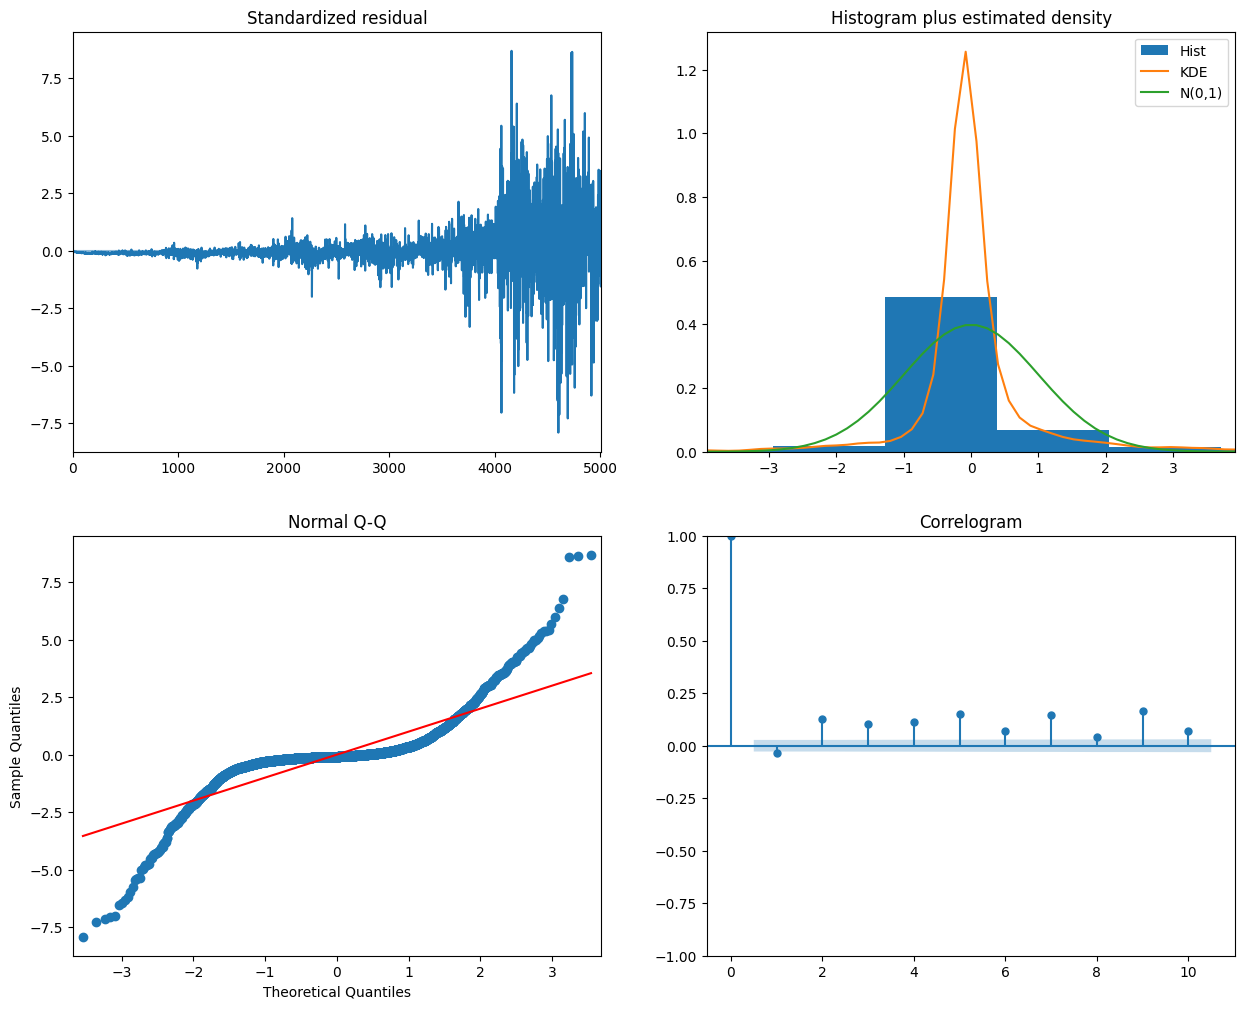

In [32]:
sarima_model.plot_diagnostics(figsize=(15,12))
plt.show()

SARIMA Model: Serialize with `Pickle`
- Serializing = Converting the model object into a format that can be easily stored in a file for later use or sharing without having to retrain.
- Pickle allows the use of 'wb' and 'rb' modes to open a file for reading or writing in binary mode.

In [35]:
# Serialize with Pickle and save it as pkl
with open('sarima_model.pkl', 'wb') as pkl:
    pickle.dump(sarima_model, pkl)

# Desiarilize the content of the file back into a Python object
with open('sarima_model.pkl', 'rb') as pkl:
    loaded_model = pickle.load(pkl)

SARIMA Model: Predicting APPL Stock Price
- Define a function named forecast that takes a time series model, a DataFrame (df), and a forecast date as input, and returns a DataFrame containing actual values, predicted values, and confidence intervals.

In [41]:
def forecast(model, df, forecast_date):
    # Forecast
    n_periods = (datetime.strptime(forecast_date, '%Y-%m-%d') - df.index[-1]).days
    fitted, confint = model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(days=1), periods = n_periods, freq='D')

    # Make series for plotting purpose
    fitted_series = pd.Series(fitted.values, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    #Concatenate the original DataFrame with forecasted values and confidence intervals
    df_result = pd.concat([df, fitted_series, lower_series, upper_series], axis=1)
    df_result.columns = ["Actual", "Prediction", "Low", "High"]

    #Inverse transform the scaled values to their original scale
    for column in df_result.columns:
      df_result[column] = Feature_Scaler.inverse_transform(df_result[column].values.reshape(-1,1))


    return df_result

SARIMA Model: Store APPL Stock Price
- Use the above defined function to store your predicted values in a `test` variable
- View what is stored in `test` variable
- Plot the range of predicted prices for APPL stock

In [51]:
test=forecast(loaded_model, apple_transformed, "2023-12-20")

/home/kevcr1122/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/kevcr1122/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [52]:
test

,Actual,Prediction,Low,High
2004-01-02,0.380000,NaN,NaN,NaN
2004-01-05,0.395893,NaN,NaN,NaN
2004-01-06,0.394464,NaN,NaN,NaN
2004-01-07,0.403393,NaN,NaN,NaN
2004-01-08,0.417143,NaN,NaN,NaN
...,...,...,...,...
2023-12-16,NaN,195.588115,192.942698,198.233533
2023-12-17,NaN,195.257247,191.409012,199.105482
2023-12-18,NaN,193.783005,189.162576,198.403434
2023-12-19,NaN,193.766116,188.586978,198.945255


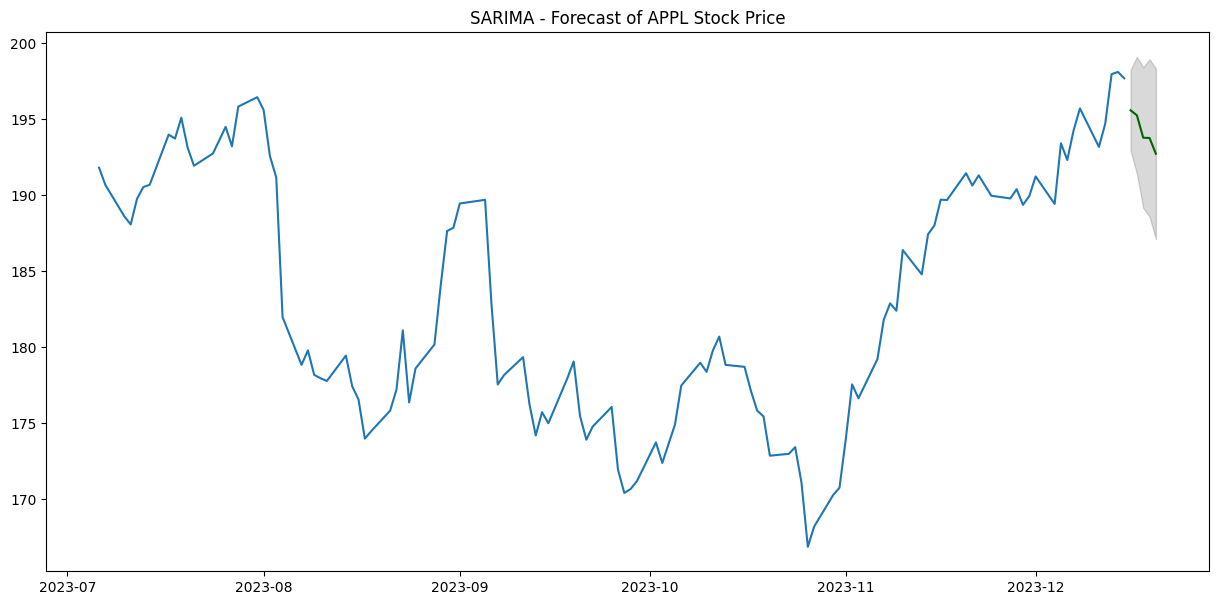

In [53]:
# Plot
plt.figure(figsize=(15,7))
plt.plot(test["Actual"][-120:], color='#1f76b4')
plt.plot(test["Prediction"], color='darkgreen')
plt.fill_between(test.index,
                test["Low"],
                test["High"],
                color='k', alpha=.15)

plt.title("SARIMA - Forecast of APPL Stock Price")
plt.show()